## Fitbit Project
### By Alan Kay
Below is my demonstration of using some basic data science methods to explore my personal Fitbit [[1]](https://apps.apple.com/us/app/fitbit-health-fitness/id462638897) data collected between August 2022 to February 2023. The source of the information was acquired through a Fitbit watch (Charge 3) and collected by exporting my personal data from my Fitbit account to a downloadable csv file. My intent was to gain experience cleaning the data (making the data more accessible and easier to manipulate), visualize the data (create graphics that help show trends and explain the data over time), and analyze the data (ask specific questions and perform statistical tests to recieve evidence towards the answers to those questions). Below is a notebook detailing how I accomplished these goals and what I found while doing so. 

**Disclaimer**: This project was for exploring data science. It is not a statement on my health or any viewpoint I might have about the health of others. 

In [1]:
import datetime
from datetime import datetime
import pandas as pd
import numpy as np
import math
from openpyxl import load_workbook
import matplotlib.pyplot as plt
plt.close("all")
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scipy.stats as stats
import Fitbit_Utilities as FbUtil

print('Import complete')

Import complete


### CLEANING

The exported csv file from Fitbit could only be a month's worth of information. Because of this limitation, I combined the exported csv files from each month into one master export file. Then, I made a temporary excel file of the master export so that I could use openpyxl to reformat the food entries, given that the nutrient section was not organized in a simple table format. 

To solve this problem, I created a function within my self-made Fitbit Utilities module to access and edit the Excel export file that has all the data from my Fitbit account. The food section isn't easy to work through so the function will organize the daily food entries into neat columns for the data points of interest (e.g. carbs, protein, fiber, etc.) and remove the rest of the data (e.g. food names, time of eating). This code produces a relabeled excel file. From the relabeled file, I then moved the updated food section to the food csv file. The code I used to accomplish this is below.

In [2]:
FbUtil.foodClean?

Now that we have a cleaned version of the exported data, we can focus on separating each of the major groups. Those groups, being Activities, Body, Food, and Sleep, are saved into a specified csv file for each group to make the creation of the dataframes simple.

Once each major group has its own csv file, we can create the dataframe for each group that will be used throughout the project.

In [3]:
df_act = pd.read_csv('fitbit_activities_8.1_2.14.csv')   #Activities DataFrame
df_body = pd.read_csv('fitbit_body_8.1_2.14.csv')        #Body DataFrame
df_food = pd.read_csv('fitbit_food_8.1_2.14.csv')        #Food DataFrame
df_sleep = pd.read_csv('fitbit_sleep_8.1_2.14.csv')      #Sleep DataFrame

print('DateFrames made')

DateFrames made


Let's take a peek at what these dataframes consist of. 

#### Activities Dataframe

In [4]:
df_act.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,8/1/2022,"2,914","5,021",2.29,14,797,191,7,0,983
1,8/2/2022,"3,871","14,798",6.69,61,739,222,36,56,"2,038"
2,8/3/2022,"2,777","3,800",1.76,11,742,176,0,0,824
3,8/4/2022,"3,113","7,393",3.43,25,682,189,8,16,"1,191"
4,8/5/2022,"2,956","6,613",3.06,21,775,155,7,30,"1,041"


In [5]:
df_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    198 non-null    object 
 1   Calories Burned         198 non-null    object 
 2   Steps                   198 non-null    object 
 3   Distance                198 non-null    float64
 4   Floors                  198 non-null    int64  
 5   Minutes Sedentary       198 non-null    object 
 6   Minutes Lightly Active  198 non-null    int64  
 7   Minutes Fairly Active   198 non-null    int64  
 8   Minutes Very Active     198 non-null    int64  
 9   Activity Calories       198 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 15.6+ KB


#### Body Dataframe

One thing to take note of is that I weighed myself quite irregularly. I didn't have a set number of days that I would wait beforing weighing myself again, so that caused some inaccuracy in the data displayed compared to reality. Fitbit automatically placed a value for days that I didn't weigh-in by connecting the previous weigh-in to the following weigh-in in a linear fashion.

In [6]:
df_body.head()

,Date,Weight,BMI,Fat
0,8/1/2022,219.13,30.68,26.1
1,8/2/2022,219.13,30.68,26.1
2,8/3/2022,219.13,30.68,26.1
3,8/4/2022,219.13,30.68,26.1
4,8/5/2022,219.13,30.68,26.1


In [7]:
df_body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    198 non-null    object 
 1   Weight  198 non-null    float64
 2   BMI     198 non-null    float64
 3   Fat     198 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.3+ KB


#### Food Dataframe
The many zeroes will be addressed shortly below this section.

In [8]:
df_food.head()

,Date,Calories In,Fat (g),Fiber (g),Carbs (g),Sodium (mg),Protein (g)
0,8/1/2022,0,0,0,0,0,0
1,8/2/2022,0,0,0,0,0,0
2,8/3/2022,0,0,0,0,0,0
3,8/4/2022,0,0,0,0,0,0
4,8/5/2022,0,0,0,0,0,0


In [9]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         198 non-null    object
 1   Calories In  198 non-null    object
 2   Fat (g)      198 non-null    int64 
 3   Fiber (g)    198 non-null    int64 
 4   Carbs (g)    198 non-null    int64 
 5   Sodium (mg)  198 non-null    int64 
 6   Protein (g)  198 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 11.0+ KB


#### Sleep Dataframe

In [10]:
df_sleep.head()

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
0,2022-08-01 2:36AM,2022-08-01 10:01AM,381,64,33,445,10.0,329.0,42.0
1,2022-08-02 1:02AM,2022-08-02 7:29AM,340,47,24,387,29.0,259.0,52.0
2,2022-08-03 1:00AM,2022-08-03 9:42AM,445,77,30,522,23.0,364.0,58.0
3,2022-08-04 1:37AM,2022-08-04 9:23AM,399,67,30,466,33.0,334.0,32.0
4,2022-08-04 6:09PM,2022-08-04 7:28PM,70,9,1,79,NaN,NaN,NaN


In [11]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Start Time            226 non-null    object 
 1   End Time              226 non-null    object 
 2   Minutes Asleep        226 non-null    int64  
 3   Minutes Awake         226 non-null    int64  
 4   Number of Awakenings  226 non-null    int64  
 5   Time in Bed           226 non-null    int64  
 6   Minutes REM Sleep     199 non-null    float64
 7   Minutes Light Sleep   199 non-null    float64
 8   Minutes Deep Sleep    199 non-null    float64
dtypes: float64(3), int64(4), object(2)
memory usage: 16.0+ KB


For many of the numbers collected from my Fitbit account, I ran into an issue where a comma would prevent the data point from being understood as a number. To fix this, I created a small function to remove the comma and change the type from a string (text) to an integer. This function is found in the Fitbit Utilities module that I made and is titled ObjtoInt. Below, I used this function to remove the commas and switch those values into integers.

In [12]:
print(FbUtil.ObjtoInt(df_act, 'Calories Burned'))
print(FbUtil.ObjtoInt(df_act, 'Steps'))
print(FbUtil.ObjtoInt(df_act, 'Minutes Sedentary'))
print(FbUtil.ObjtoInt(df_act, 'Activity Calories'))
print(FbUtil.ObjtoInt(df_food, 'Calories In'))

Objects Changed to Integers Complete
Objects Changed to Integers Complete
Objects Changed to Integers Complete
Objects Changed to Integers Complete
Objects Changed to Integers Complete


I also will change the Date columns to a more appropriate format using the Pandas function to_datetime.

In [13]:
df_act['Date'] = pd.to_datetime(df_act['Date'])
df_body['Date'] = pd.to_datetime(df_body['Date'])
df_food['Date'] = pd.to_datetime(df_food['Date'])
df_sleep['Start Time'] = pd.to_datetime(df_sleep['Start Time'])
df_sleep['End Time'] = pd.to_datetime(df_sleep['End Time'])

print('Date formatting complete')

Date formatting complete


With many days where I did not enter my food into Fitbit, there are obvious gaps in the Food Dataframe. This has already been shown in the header view of the Food Dataframe, hence the many zeroes. We can create a list that places a Nan (Not a number) value to state that entry as non-existent. When recording food entries, I followed the practice of emptying any daily entries that didn't include a full log of food for that day, so any day with more than 100 calories recorded should be complete food logs. I created another function in the Fitbit Utilities module to create the list of NaN values in place of non-entries in the food dataFrame, as seen below.

In [14]:
FoodEntriesClean = FbUtil.xFoodNonEntries(df_food, 100, 'Calories In')

# Sample of the list showing the null values for non-entries
FoodEntriesClean[8:16]

[nan, nan, nan, nan, 3108, 2395, 2607, 3141]

With similar reasoning, I will do the same with protein and sodium as we will look at these later on as well.

In [15]:
CleanProt = FbUtil.xFoodNonEntries(df_food, 1, 'Protein (g)')

# Sample of the list showing the null values for non-entries
CleanProt[8:16]

[nan, nan, nan, nan, 66, 16, 89, 153]

In [16]:
CleanSod = FbUtil.xFoodNonEntries(df_food, 100, 'Sodium (mg)')

# Sample of the list showing the null values for non-entries
CleanSod[8:16]

[nan, nan, nan, nan, 3891, 729, 3606, 6600]

Now that the dataframes are made and cleaned up a bit, lets start using them to make some calculations. First, lets find out what my **fat mass** and **lean mass** are with the cell below. Lean mass will be calculated as my body weight minus the weight of fat tissue based on my body fat percentage. Fat mass will be calculated as my fat percentage, which was recorded from my scale used for weigh-ins, multiplied by my total weight.

In [17]:
FatMass = df_body.T.loc['Weight'] * (df_body.T.loc['Fat'] / 100)
LeanMass = df_body.T.loc['Weight'] - FatMass

print('LeanMass and FatMass calculations done')

LeanMass and FatMass calculations done


Now lets add **fat mass** and **lean mass** to the Body Dataframe

In [18]:
df_body['Fat Mass'] = round(pd.to_numeric(FatMass), 2)
df_body['Lean Mass'] = round(pd.to_numeric(LeanMass), 2)

df_body.head()

,Date,Weight,BMI,Fat,Fat Mass,Lean Mass
0,2022-08-01,219.13,30.68,26.1,57.19,161.94
1,2022-08-02,219.13,30.68,26.1,57.19,161.94
2,2022-08-03,219.13,30.68,26.1,57.19,161.94
3,2022-08-04,219.13,30.68,26.1,57.19,161.94
4,2022-08-05,219.13,30.68,26.1,57.19,161.94


In [19]:
df_body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       198 non-null    datetime64[ns]
 1   Weight     198 non-null    float64       
 2   BMI        198 non-null    float64       
 3   Fat        198 non-null    float64       
 4   Fat Mass   198 non-null    float64       
 5   Lean Mass  198 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 9.4 KB


At this point, I am happy with the condition of the dataFrames and will move on to exploring the data.

### Visualization

To visualize the data, I used the well-known python modules of Pandas and Matplotlib to create graphs that I was interested in seeing.

One of the first graphs I made was done less so to explore the data and more so to become familiar with matplotlib and pyplot. These two graphs display a comparison of daily steps taken to calories burned. 

Text(0.5, 1.0, 'Daily Step Count (Point Size) compared to Calories Burned')

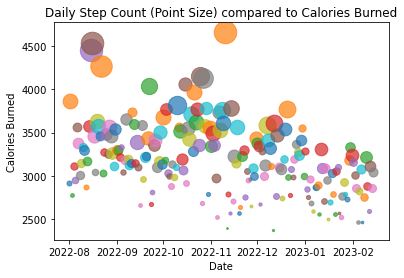

In [20]:
stepsizemodif = df_act.T.loc["Steps"] / 1000            #choosing 1000 is arbitrary, dictates point size
plt.figure()
templist = zip(df_act.T.loc["Date"], df_act.T.loc["Calories Burned"], stepsizemodif)
for place in templist:
    plt.plot(place[0], place[1], markersize = place[2], marker = 'o', alpha = 0.7)
plt.xlabel("Date")
plt.ylabel("Calories Burned")
plt.title("Daily Step Count (Point Size) compared to Calories Burned")

and lets switch the variables so that the size of the dot is represented by calories burned instead of steps taken...

Text(0.5, 1.0, 'Calories Burned (Point Size) compared to Daily Step Count')

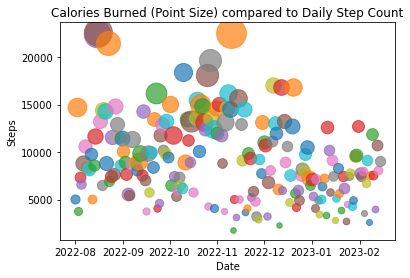

In [21]:
calburnsizemodif = df_act.T.loc["Calories Burned"] / 1200           # choosing 1200 is arbitrary, dictates point size
plt.figure()
templist = zip(df_act.T.loc["Date"], df_act.T.loc["Steps"], calburnsizemodif)
for place in templist:
    plt.plot(place[0], place[1], markersize = place[2]**2.5, marker = 'o', alpha = 0.7)     # 2.5 is arbitrary, dictates 
plt.xlabel("Date")                                                                          # the variation of point size
plt.ylabel("Steps")
plt.title("Calories Burned (Point Size) compared to Daily Step Count")

Athlough we don't have a correlation value, it is still pretty easy to see a positive relationship between the amount of steps taken that day and the calories burned by the bigger dots being higher on the graphs. A fun observation to note is the decrease in frequency of daily steps above 15,000 occuring right around the time that the temperature in Ann Arbor was frequently below 40 degrees Fahrenheit. 

In order to view some time series, there will need to be some x-axis tick marks for the Date columns. 

In [22]:
body_Datetimes = [str(pd.Timestamp.to_pydatetime(x).date()) for x in df_body.T.loc['Date']]
bodyDateticks = body_Datetimes[::math.floor(len(body_Datetimes) / 10)]
bodyDateticksTight = body_Datetimes[::math.floor(len(body_Datetimes) / 5)]

print('Date ticks made for time series graphs')

Date ticks made for time series graphs


I will also create some evenly spaced tick marks for the BMI values.

In [23]:
bmi_ticks = np.linspace(min(df_body.T.loc['BMI']), max(df_body.T.loc['BMI']), 8)
bmi_ticks = [round(x, 2) for x in bmi_ticks]

print('BMI ticks made for BMI graph')

BMI ticks made for BMI graph


For the first time series, I wanted to compare my total body weight to my lean mass weight. I was also curious in seeing the difference between the amount of fat mass that I loss relative to the amount of lean mass that I loss during my time of working on this project.

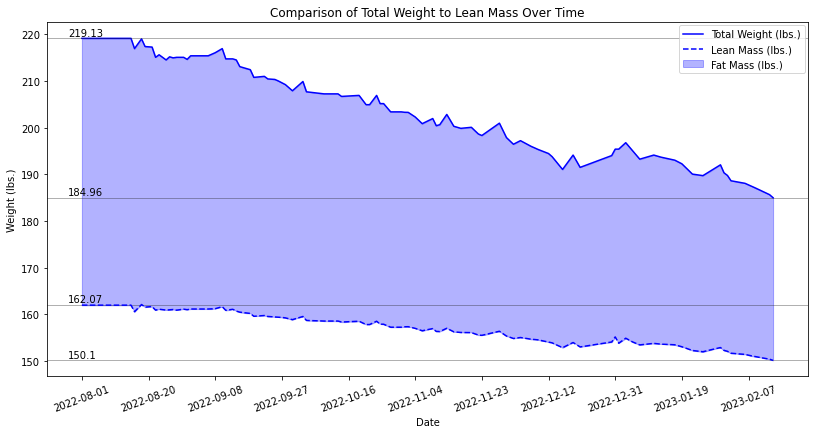

In [24]:
#Creating Figure
fig_Weight2LMass = plt.figure(figsize = (12, 6))
axes_Weight2LMass = fig_Weight2LMass.add_axes([0.07, 0.12, 0.88, 0.82])
#Creating Labels
axes_Weight2LMass.set_xlabel('Date')
axes_Weight2LMass.set_ylabel('Weight (lbs.)')
axes_Weight2LMass.set_title('Comparison of Total Weight to Lean Mass Over Time')
#Plotting Data and Horizontal Lines + Tick Marks
axes_Weight2LMass.plot(body_Datetimes, df_body.T.loc['Weight'], label = 'Total Weight (lbs.)', color = 'blue')
plt.xticks(bodyDateticks, bodyDateticks, rotation = 20)
axes_Weight2LMass.text(-4, max(list(df_body.T.loc['Weight'])) + 0.5, max(list(df_body.T.loc['Weight'])))
axes_Weight2LMass.text(-4, min(list(df_body.T.loc['Weight'])) + 0.5, min(list(df_body.T.loc['Weight'])))
axes_Weight2LMass.text(-4, max(list(df_body.T.loc['Lean Mass'])) + 0.5, max(list(df_body.T.loc['Lean Mass'])))
axes_Weight2LMass.text(-4, min(list(df_body.T.loc['Lean Mass'])) + 0.5, min(list(df_body.T.loc['Lean Mass'])))
plt.axhline(y = max(list(df_body.T.loc['Weight'])), lw = 0.5, alpha = 0.7, color = '#1f1f1f')
plt.axhline(y = min(list(df_body.T.loc['Weight'])), lw = 0.5, alpha = 0.7, color = '#1f1f1f')
plt.axhline(y = max(list(df_body.T.loc['Lean Mass'])), lw = 0.5, alpha = 0.7, color = '#1f1f1f')
plt.axhline(y = min(list(df_body.T.loc['Lean Mass'])), lw = 0.5, alpha = 0.7, color = '#1f1f1f')
axes_Weight2LMass.plot(body_Datetimes, df_body.T.loc['Lean Mass'], label = 'Lean Mass (lbs.)', ls = '--', color = 'blue')
#Shading and Legend
LeanMassVals = [round(float(x),1) for x in df_body.T.loc['Lean Mass']]
TotalWeightVals = [round(float(x),1) for x in df_body.T.loc['Weight']]
axes_Weight2LMass.fill_between(body_Datetimes, LeanMassVals, TotalWeightVals, alpha = 0.3, color = 'blue',
                               label = 'Fat Mass (lbs.)')
axes_Weight2LMass.legend(loc = (0.831, 0.8555))

The next times series is a graph showing my BMI score from August to February. I wanted to display my BMI score overtime with the background displaying the categories for the different BMI scores [[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4890841/).

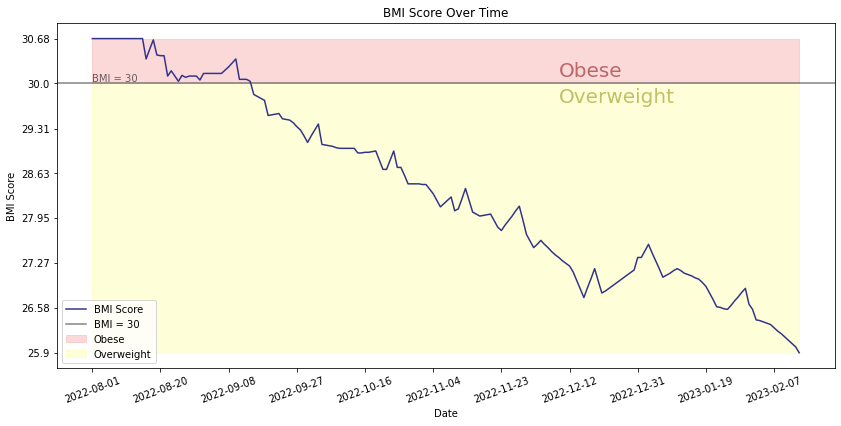

In [25]:
fig_bmi = plt.figure(figsize = (12, 6))
axes_bmi = fig_bmi.add_axes([0.07, 0.13, 0.9, 0.8])
axes_bmi.plot(body_Datetimes, df_body.T.loc['BMI'], color = '#333388', label = 'BMI Score')
axes_bmi.set_xlabel('Date')
axes_bmi.set_ylabel('BMI Score')
axes_bmi.set_title('BMI Score Over Time')
plt.axhline(y = 30, color = '0.25', alpha = 0.65, label = 'BMI = 30')
plt.text(0, 30.025, 'BMI = 30', color = '0.1', alpha = 0.65)
plt.yticks(bmi_ticks, bmi_ticks)
plt.xticks(bodyDateticks, bodyDateticks, rotation = 20)
BMIVals = [x for x in df_body.T.loc['BMI']]
axes_bmi.fill_between(body_Datetimes, 30, max(BMIVals), alpha = 0.4, color = '#f9a1a1', label = 'Obese')
plt.text(130, 30.1, 'Obese', color = '#b96161', alpha = 0.95, size = 20)
axes_bmi.fill_between(body_Datetimes, 30, min(BMIVals), alpha = 0.4, color = '#fdfda0', label = 'Overweight')
plt.text(130, 29.7, 'Overweight', color = '#bdbd60', alpha = 0.95, size = 20)
axes_bmi.legend(loc = 3)

An interesting feature of Fitbit is that it saves the total amount of minutes that you spent at a certain activity level. With these recordings, We can see the breakdown of activity levels throughout each day.

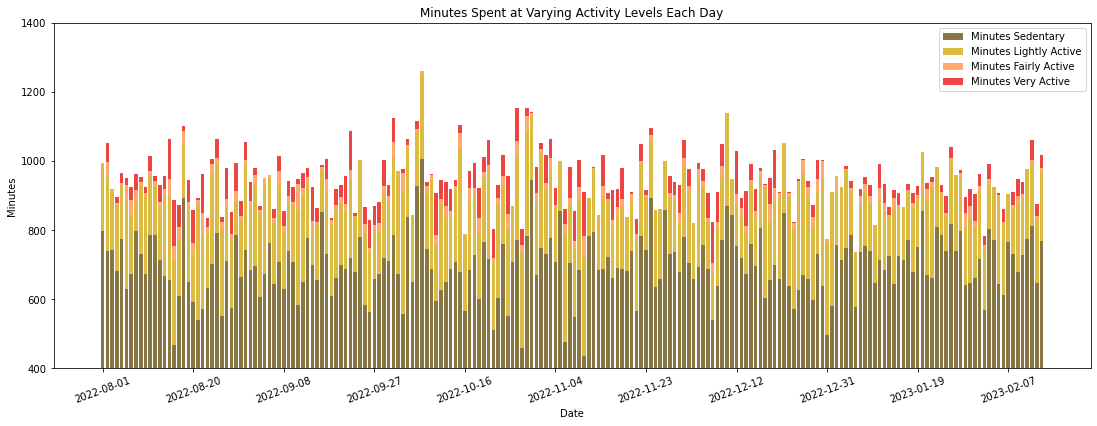

In [65]:
fig_activeMinutes = plt.figure(figsize = (16, 6))
axes_activeMinutes = fig_activeMinutes.add_axes([0.07, 0.13, 0.9, 0.8])
width_actmin = 0.75
axes_activeMinutes.bar(body_Datetimes, df_act.T.loc['Minutes Sedentary'], width = width_actmin, color = '#887744', 
                       label = 'Minutes Sedentary')
axes_activeMinutes.bar(body_Datetimes, df_act.T.loc['Minutes Lightly Active'], width = width_actmin, color = '#ddbb40',
                       bottom = df_act.T.loc['Minutes Sedentary'], label = 'Minutes Lightly Active')
axes_activeMinutes.bar(body_Datetimes, df_act.T.loc['Minutes Fairly Active'], width = width_actmin, color = '#ffaa70',
                       bottom = df_act.T.loc['Minutes Sedentary'] + df_act.T.loc['Minutes Lightly Active'],
                       label = 'Minutes Fairly Active')
axes_activeMinutes.bar(body_Datetimes, df_act.T.loc['Minutes Very Active'], width = width_actmin, color = '#ee4444',
                       bottom = df_act.T.loc['Minutes Sedentary'] + df_act.T.loc['Minutes Lightly Active'] +
                        df_act.T.loc['Minutes Fairly Active'], label = 'Minutes Very Active')
axes_activeMinutes.set_xlabel('Date')
axes_activeMinutes.set_ylabel('Minutes')
axes_activeMinutes.set_title('Minutes Spent at Varying Activity Levels Each Day')
plt.ylim([400, 1400])
plt.xticks(bodyDateticks, bodyDateticks, rotation = 20)
axes_activeMinutes.legend()

The graphs below are subplots comparing Calories Burned to Calories Consumed next to Net Calories over time. During the time of recording my Fitbit data, I was focused on meeting a caloric deficit goal for each day, which explains the primarily negative net calories.

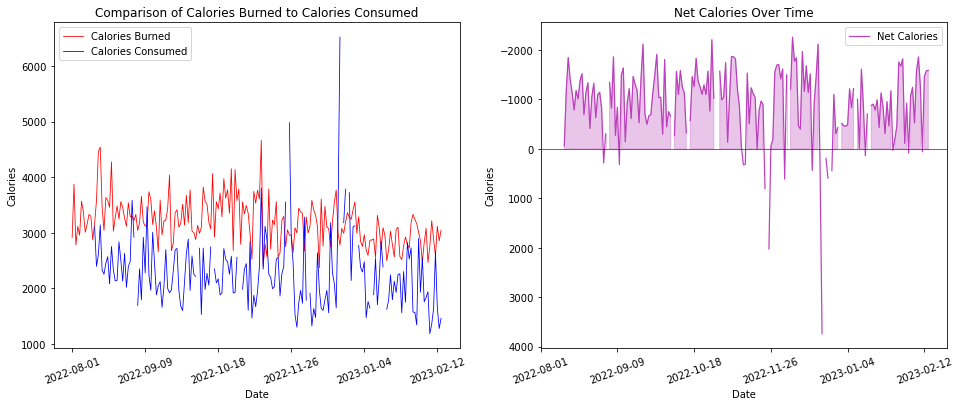

In [27]:
fig_calComp = plt.figure(figsize = (16, 6))
axes_calComp1 = fig_calComp.add_subplot(121)
axes_calComp2 = fig_calComp.add_subplot(122)
axes_calComp1.plot(body_Datetimes, df_act.T.loc['Calories Burned'], color = 'red', lw = 0.8, label = 'Calories Burned')
axes_calComp1.plot(body_Datetimes, FoodEntriesClean, color = 'blue', lw = 0.8, label = 'Calories Consumed')
axes_calComp2.plot(body_Datetimes, (FoodEntriesClean - df_act.T.loc['Calories Burned'].astype('float64')),
                     color = '#bb40bb', lw = 1.2, label = 'Net Calories')
axes_calComp1.set_xlabel('Date')
axes_calComp1.set_ylabel('Calories')
axes_calComp1.set_title('Comparison of Calories Burned to Calories Consumed')
axes_calComp2.set_xlabel('Date')
axes_calComp2.set_ylabel('Calories')
axes_calComp2.set_title('Net Calories Over Time')
axes_calComp2.fill_between(body_Datetimes, 0, 
                           (FoodEntriesClean - df_act.T.loc['Calories Burned']).astype('float64'),
                           where = ((FoodEntriesClean - df_act.T.loc['Calories Burned'].astype('float64')) < 0),
                           alpha = 0.3, color = '#bb40bb')
plt.sca(axes_calComp1)
plt.xticks(bodyDateticksTight, bodyDateticksTight, rotation = 20)
plt.sca(axes_calComp2)
plt.xticks(bodyDateticksTight, bodyDateticksTight, rotation = 20)
plt.axhline(y = 0, color = '0.1', alpha = 0.8, lw = 0.8)
plt.gca().invert_yaxis()
axes_calComp1.legend()
axes_calComp2.legend()

Macronutrients are a trendy topic, and so I was interested in seeing how I performed compared to the daily recommended protein intake suggested by this 2007 paper published in the American Journal of Clinical Nutrition which suggests the consumption of 0.93 grams of protein per kilogram of bodyweight [[3]](https://academic.oup.com/ajcn/article/86/4/995/4649413). 

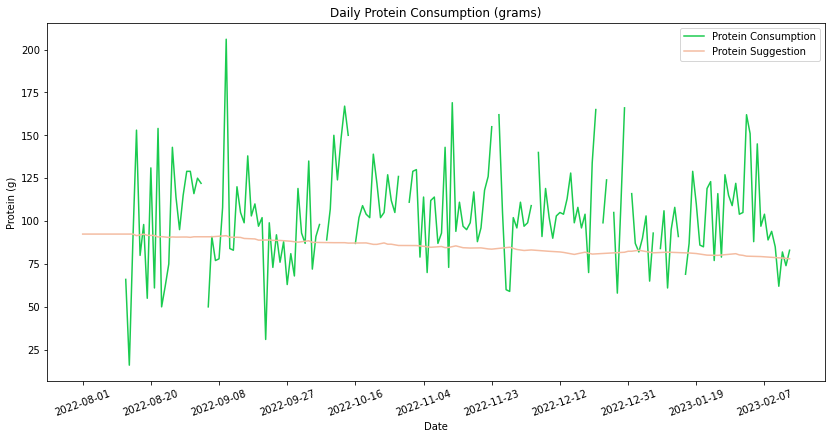

In [28]:
fig_protRec = plt.figure(figsize = (12, 6))
axes_protRec = fig_protRec.add_axes([0.07, 0.12, 0.9, 0.83])
protRec = 0.93 * (df_body.T.loc['Weight'] / 2.205)
axes_protRec.plot(body_Datetimes, CleanProt, color = '#1ACB4F', label = 'Protein Consumption')
axes_protRec.plot(body_Datetimes, protRec, color = '#F4BCA1', label = 'Protein Suggestion')
axes_protRec.set_xlabel('Date')
axes_protRec.set_ylabel('Protein (g)')
axes_protRec.set_title('Daily Protein Consumption (grams)')
plt.xticks(bodyDateticks, bodyDateticks, rotation = 20)
axes_protRec.legend()

Sodium is another nutrient that commonly pops up in conversations around proper dieting. The current conversation seems to be around limiting sodium intake to be below 2300 mg per day [[4]](https://www.cdc.gov/salt/food.htm). I checked to see if there was a minimal amount that seemed safe and found that 500 mg per day was expected to be okay [[5]](https://www.heart.org/en/healthy-living/healthy-eating/eat-smart/sodium/how-much-sodium-should-i-eat-per-day#:~:text=There's%20no%20reliable%20evidence%20that,in%20less%20than%20%C2%BC%20teaspoon). I wasn't tracking sodium consumption during this time period, so I likely didn't do a very good job, but I still wanted to compare my consumption to the 2300 mg mark and the 500 mg mark.

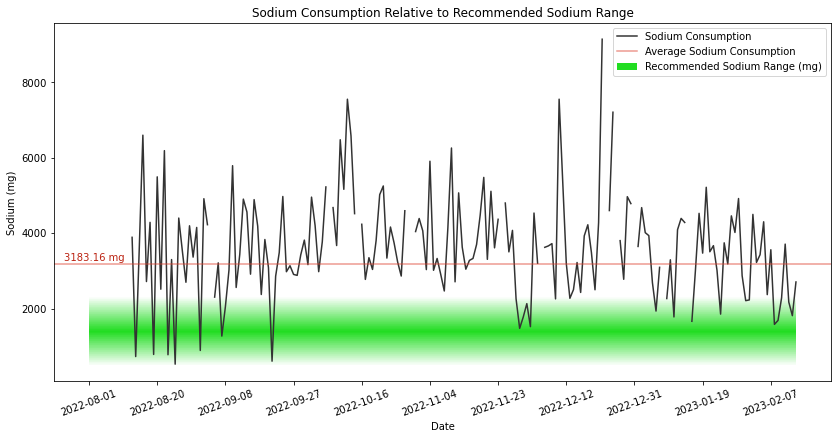

In [29]:
fig_SodRec = plt.figure(figsize = (12, 6))
axes_SodRec = fig_SodRec.add_axes([0.07, 0.12, 0.9, 0.83])
# Parameters for FillBetween Shading
HighSod = 2300
LowSod = 500
halfPoint = (HighSod + LowSod) / 2
alphaNum = 1
RangeNum = 50
medialLim = halfPoint
for i in list(range(RangeNum)):
    # Top Half Shading
    distalLim = medialLim + ((HighSod - halfPoint) / RangeNum)
    axes_SodRec.fill_between(body_Datetimes, medialLim, distalLim, alpha = alphaNum, color = '#22DD22', linewidth = 0.0)
    # Bottom Half Shading
    flipmLim = halfPoint - (medialLim - halfPoint)
    flipdLim = halfPoint - (distalLim - halfPoint)
    axes_SodRec.fill_between(body_Datetimes, flipmLim, flipdLim, alpha = alphaNum, color = '#22DD22', linewidth = 0.0)
    # Setting Variables to New Values for next interval
    alphaNum -= 1 / RangeNum
    medialLim += (HighSod - halfPoint) / RangeNum
# Plotting
axes_SodRec.plot(body_Datetimes, CleanSod, color = '#333333', lw = 1.5)
avSod = round(sum(pd.Series(CleanSod).fillna(0)) / len(pd.Series(CleanSod).fillna(0)), 2)
plt.axhline(y = avSod, color = '#DD4433', alpha = 0.55)
plt.text(-7, avSod + 100, '{} mg'.format(avSod), color = '#BB2211', size = 10)
# Labeling
axes_SodRec.set_xlabel('Date')
axes_SodRec.set_ylabel('Sodium (mg)')
axes_SodRec.set_title('Sodium Consumption Relative to Recommended Sodium Range')
# Tick Mark Editing
plt.xticks(bodyDateticks, bodyDateticks, rotation = 20)
# Legend
legendElements = [Line2D([0], [0], color = '#333333', lw = 1.5, label = 'Sodium Consumption'),
       Line2D([0], [0], color = '#DD4433', alpha = 0.55, label = 'Average Sodium Consumption'),
       Patch(facecolor = '#22DD22', label = 'Recommended Sodium Range (mg)')]    
axes_SodRec.legend(handles = legendElements)

Based on the graph produced, it appears that I am generally not reaching the target of having less than 2300 mg of sodium. Perhaps this is a target I can focus on in the future. 

### Analysis

Now that we have visualized some of the data, we can start asking some direct questions and analyzing it to get some answers. The questions that I would like to ask are as follows:
 - Is there a correlation between _weight change_ and _net calories_?
 - What feature is most correlated with the _Calories Burned_ data?

##### Question 1

For the first question, we will find out if there is a correlation between weight change and net calories. To do so, we will compare the net calories of one day to the weight change, which will be a calculation of that day's weight subtracted by the following day's weight. Some things to note before this is completed:
 - Given that I didn't weigh myself every morning, there will be some inaccuracy in the weight data representation. As stated earlier, Fitbit fills in the values of days where I didn't weigh myself by linearly connecting adjacent weigh-ins.
 - We have to again acknowledge days where food entries were not made and so these days are zeroed out. To avoid these extreme points from strongly affecting the results, we remove those dates from both variable datasets as a way to mediate inaccuracy.

To determine if there is a correlation, we will first need to see if the data being used is normally distributed. This will help us decide whether to use a Pearson's R test or a Spearman's Ranked Correlation test. Histograms and a scatterplot will be created for the variables of interest after they are put into a new dataFrame.

In [30]:
# variables in question are weight change (day of weight minus following day weight) and net calories (day of net calories).
# Net Calories Series
netCals = FoodEntriesClean - df_act.T.loc['Calories Burned']
netCals = netCals.rename('Net Calories').tail(-1)   # Renaming and removing first day to align the netCal values with 
# Weight Changes Series                             # weightChange values
weightLog = []
weightChange = []
for day in df_body.T.loc['Weight']:
    weightLog.append(day)
    try:
        weightChange.append(weightLog[-1] - weightLog[-2])
    except:
        pass
weightChange = pd.Series(weightChange, name = 'Weight Change')

# Merging the two series and Removing Rows where Nan values (food non-entries) are found
df_WvN = pd.DataFrame([netCals, weightChange]).T.dropna().reset_index(drop = True)

# Resulting Variables in a Dataframe
df_WvN

,Net Calories,Weight Change
0,-60.0,0.00
1,-1186.0,0.00
2,-1850.0,-2.20
3,-1401.0,1.05
4,-1136.0,1.04
...,...,...
168,-1861.0,-0.36
169,-1249.0,-0.35
170,60.0,-0.35
171,-1468.0,-0.36


Now for the histograms and the scatterplot.

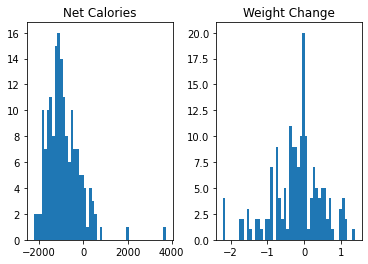

In [71]:
WvNhist = df_WvN.hist(bins = 50, grid = False)

Text(0.5, 1.0, 'Scatterplot of Weight Change Versus Net Calories')

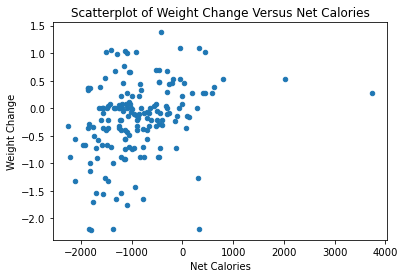

In [32]:
WvNscatter = df_WvN.plot.scatter('Net Calories', 'Weight Change')
WvNscatter
plt.title('Scatterplot of Weight Change Versus Net Calories')

It looks like neither variable is normally distributed from a brief look at the histograms. It also looks like the scatterplot doesn't show a strong correlation. Since there is suspicion as to whether the variables are normally distributed or not, we can run a Shapiro-Wilk test for both variables to get values on the normality.

In [33]:
stats.shapiro(df_WvN.T.loc['Net Calories'])

ShapiroResult(statistic=0.8958052396774292, pvalue=1.1222516249631553e-09)

In [34]:
stats.shapiro(df_WvN.T.loc['Weight Change'])

ShapiroResult(statistic=0.9653340578079224, pvalue=0.0002645171189215034)

As shown by the Shapiro-Wilk tests, neither variable is expected to be normally distributed. For this reason, we will use the Spearman Ranked Correlation tests. Given the scatterplot, we are expected a pretty weak correlation if there is one at all.

In [35]:
stats.spearmanr(df_WvN.T.loc['Net Calories'], df_WvN.T.loc['Weight Change'])

SpearmanrResult(correlation=0.31865671245301364, pvalue=1.9302374003991625e-05)

Based on the Spearman Ranked Correlation test, we can see that there is some sigificant evidence of a relatively weak, positive correlation. In the future, it might be better to adjust for confoudning variables (e.g. water intake, exercise activity, sleep quality) with a more controlled environment and schedule, increase the number of dates to evaluate, and to also consider weight change averaged over a longer time period to decrease chances of comparing sporadic changes in diet from being compared to the less sporadic occurrences in weight change.

##### Question 2

The second question is about doing a correlation comparison. This means that we will be doing more of the same, but instead of only trying to see if there is a correlation, we will also compare the correlation coefficients of the different features to the other features of interest. Only features with a p-value less than 0.05 in the correlation test will be considered.

The correlation comparison poses the question of which feature is most correlated to calories burned in a day. The features of interest are daily steps, daily distance, floors, sum of active minutes, sleep minutes, protein (g) consumed, and bodyweight. Of course, we must note that for answering this question, along with all other points made in this project, there are many confounding variables that aren't being considered in testing or measured throughout the project. This will be expanded on a bit more at the end, but is important to mention now as we focus on this question.  

I'd like to briefly define each metric being compared before we continue in order to help prevent confusion: \
**Calories Burned**: Daily amount of calories burned that day \
**Daily Steps**: daily amount of steps taken that day \
**Daily Distance**: distance traveled that day (in miles) \
**Floors**: flight of stairs traveled in a day \
**Sum of Active Minutes**: Total minutes recorded at any activity level (including lightly active, fairly active, and very active) \
**Sleep Minutes**: Total minutes slept the night prior \
**Protein (g) Consumed**: amount of protein consumed that day in grams \
**Bodyweight**: total bodyweight in lbs. for that day

Let us start by creating a dataframe containing each metric. 

In [36]:
# Creating Series
calBurned = df_act.T.loc['Calories Burned']
dStep = df_act.T.loc['Steps']
dDist = df_act.T.loc['Distance']
dFloor = df_act.T.loc['Floors']
actMin = df_act.T.loc['Minutes Lightly Active'] + df_act.T.loc['Minutes Fairly Active'] + df_act.T.loc['Minutes Very Active']
sleepMin = df_sleep.T.loc['Minutes Asleep']
prot = pd.Series(CleanProt)    # Being reused from Cleaning section
bWeight = df_body.T.loc['Weight']

# ISSUE: Minutes Asleep has more rows than other Series (Believe it is due to falling asleep more than once a day)
calCorr_issue = pd.DataFrame([calBurned, dStep, dDist, dFloor, actMin, sleepMin, prot, bWeight]).T
calCorr_issue

,Calories Burned,Steps,Distance,Floors,Unnamed 0,Minutes Asleep,Unnamed 1,Weight
0,2914.0,5021.0,2.29,14.0,198.0,381.0,NaN,219.13
1,3871.0,14798.0,6.69,61.0,314.0,340.0,NaN,219.13
2,2777.0,3800.0,1.76,11.0,176.0,445.0,NaN,219.13
3,3113.0,7393.0,3.43,25.0,213.0,399.0,NaN,219.13
4,2956.0,6613.0,3.06,21.0,192.0,70.0,NaN,219.13
...,...,...,...,...,...,...,...,...
221,NaN,NaN,NaN,NaN,NaN,432.0,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,320.0,NaN,NaN
223,NaN,NaN,NaN,NaN,NaN,402.0,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,475.0,NaN,NaN


In [68]:
calCorr_issue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Calories Burned  198 non-null    float64
 1   Steps            198 non-null    float64
 2   Distance         198 non-null    float64
 3   Floors           198 non-null    float64
 4   Unnamed 0        198 non-null    float64
 5   Minutes Asleep   226 non-null    float64
 6   Unnamed 1        174 non-null    float64
 7   Weight           198 non-null    float64
dtypes: float64(8)
memory usage: 15.9 KB


As you might notice, the end of this dataframe looks a little strange. Outside of the issue of some unnamed titles, we also have a row that is much longer than the others. This comes from the sleep data recording anytime that I seemed to be asleep, including naps. Therefore, there are a greater number of entries for Minutes Asleep instead of the once-a-day entries from the other columns. To make the Minutes Asleep easier to work with, I am going to select for the largest 198 entries in Minutes Asleep assuming that any nap I had would be shorter than the sleep I recieved overnight. 

To help show that my logic might be on the right track, I will create a histogram to hopefully see two separate groups that can be split by naps versus overnight sleep.

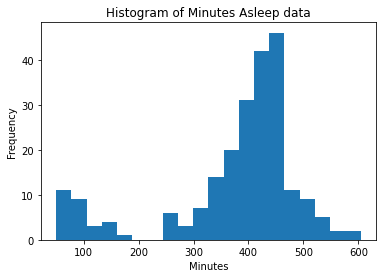

In [69]:
df_sleep.T.loc['Minutes Asleep'].hist(bins = 20)
plt.title('Histogram of Minutes Asleep data')
axesHistMinSleep = plt.gca()
axesHistMinSleep.set_xlabel('Minutes')
axesHistMinSleep.set_ylabel('Frequency')
axesHistMinSleep.grid(False)

There does seem to be two separate groups for the Minutes Asleep data. I will select for the largest recordings that match the length of dates collected so that the column is the same length as the other features.

In [67]:
sleep_limiter = 450
df_sleep_lim = df_sleep[df_sleep.T.loc['Minutes Asleep'] > sleep_limiter]
while len(df_sleep_lim) < len(df_act.T.loc['Calories Burned']):
    df_sleep_lim = df_sleep[df_sleep.T.loc['Minutes Asleep'] > sleep_limiter]
    sleep_limiter -= 2
sleepLim = df_sleep_lim.T.loc['Minutes Asleep'].reset_index(drop = True)
    
sleepLim

0      381
1      340
2      445
3      399
4      270
      ... 
193    432
194    320
195    402
196    475
197    367
Name: Minutes Asleep, Length: 198, dtype: object

Out of curiousity, I want to see the minimum of the entries just collected to see if we can draw a line between 200 minutes slept to separate naps from overnight sleep.

In [39]:
sleepLim.min()

245

As suspected from the histogram, it appears that all recorded minutes above the 200 minute limit appear to match the amount of dates in our data. This is a good sign that we have eliminated all naps and what remains are all the recorded minutes of overnight sleep, although we can not say that we are 100% sure of this. Still, we will continue with what we have.

Let us recreate the dataframe for our correlation comparison with the new sleep series.

In [40]:
calCorr = pd.DataFrame([calBurned, dStep, dDist, dFloor, actMin, sleepLim, prot, bWeight]).T
calCorr

,Calories Burned,Steps,Distance,Floors,Unnamed 0,Minutes Asleep,Unnamed 1,Weight
0,2914.0,5021.0,2.29,14.0,198.0,381.0,NaN,219.13
1,3871.0,14798.0,6.69,61.0,314.0,340.0,NaN,219.13
2,2777.0,3800.0,1.76,11.0,176.0,445.0,NaN,219.13
3,3113.0,7393.0,3.43,25.0,213.0,399.0,NaN,219.13
4,2956.0,6613.0,3.06,21.0,192.0,270.0,NaN,219.13
...,...,...,...,...,...,...,...,...
193,2885.0,7643.0,3.55,42.0,212.0,432.0,85.0,186.68
194,2587.0,4036.0,1.87,28.0,201.0,320.0,62.0,186.33
195,3117.0,10715.0,4.89,49.0,250.0,402.0,82.0,185.98
196,2855.0,8085.0,3.67,27.0,228.0,475.0,74.0,185.62


Great, the number of entries in each feature seems to match. Now let's fix the titles that are left unnamed.

In [41]:
actMin = actMin.rename('Active Minutes')
prot = prot.rename('Protein Consumed')

print('Column renaming complete')

Column renaming complete


In [42]:
calCorr = pd.DataFrame([calBurned, dStep, dDist, dFloor, actMin, sleepLim, prot, bWeight]).T
calCorr

,Calories Burned,Steps,Distance,Floors,Active Minutes,Minutes Asleep,Protein Consumed,Weight
0,2914.0,5021.0,2.29,14.0,198.0,381.0,NaN,219.13
1,3871.0,14798.0,6.69,61.0,314.0,340.0,NaN,219.13
2,2777.0,3800.0,1.76,11.0,176.0,445.0,NaN,219.13
3,3113.0,7393.0,3.43,25.0,213.0,399.0,NaN,219.13
4,2956.0,6613.0,3.06,21.0,192.0,270.0,NaN,219.13
...,...,...,...,...,...,...,...,...
193,2885.0,7643.0,3.55,42.0,212.0,432.0,85.0,186.68
194,2587.0,4036.0,1.87,28.0,201.0,320.0,62.0,186.33
195,3117.0,10715.0,4.89,49.0,250.0,402.0,82.0,185.98
196,2855.0,8085.0,3.67,27.0,228.0,475.0,74.0,185.62


Another concern is that days where food entries where not made will be compared to other features when there is no data to compare. This is seen as NaN values under the Protein Consumed feature. We will drop the rows with NaN values so that there is a completely filled in row of values for every row considered in the correlation tests. After doing so, we will also reset the index values to match the new length of the dataFrame.

In [43]:
calCorr = calCorr.dropna().reset_index(drop = True)
calCorr

,Calories Burned,Steps,Distance,Floors,Active Minutes,Minutes Asleep,Protein Consumed,Weight
0,3168.0,8674.0,4.03,34.0,216.0,432.0,66.0,219.13
1,3581.0,11717.0,5.31,39.0,289.0,425.0,16.0,219.13
2,4457.0,22404.0,10.37,107.0,409.0,442.0,89.0,219.13
3,4542.0,22612.0,10.48,95.0,420.0,328.0,153.0,216.93
4,3466.0,13228.0,6.08,39.0,263.0,414.0,80.0,217.98
...,...,...,...,...,...,...,...,...
169,2885.0,7643.0,3.55,42.0,212.0,432.0,85.0,186.68
170,2587.0,4036.0,1.87,28.0,201.0,320.0,62.0,186.33
171,3117.0,10715.0,4.89,49.0,250.0,402.0,82.0,185.98
172,2855.0,8085.0,3.67,27.0,228.0,475.0,74.0,185.62


Now we will check for normality of the features by looking at the histograms and showing the scatterplots of each feature compared to calories burned.

array([[<AxesSubplot:title={'center':'Calories Burned'}>,
        <AxesSubplot:title={'center':'Steps'}>,
        <AxesSubplot:title={'center':'Distance'}>],
       [<AxesSubplot:title={'center':'Floors'}>,
        <AxesSubplot:title={'center':'Active Minutes'}>,
        <AxesSubplot:title={'center':'Minutes Asleep'}>],
       [<AxesSubplot:title={'center':'Protein Consumed'}>,
        <AxesSubplot:title={'center':'Weight'}>, <AxesSubplot:>]],
      dtype=object)

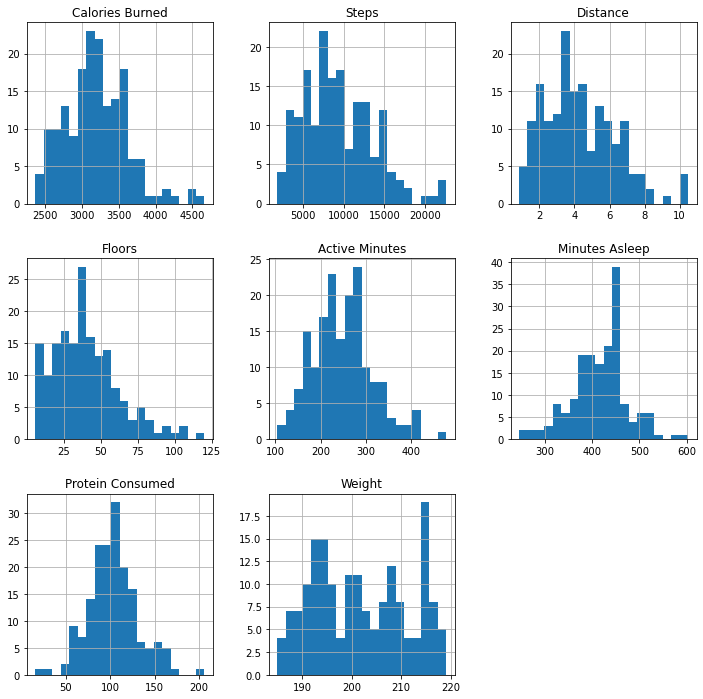

In [44]:
calCorr.hist(bins = 20, figsize = (12, 12))

Text(0.5, 1.0, 'Weight versus Calories Burned')

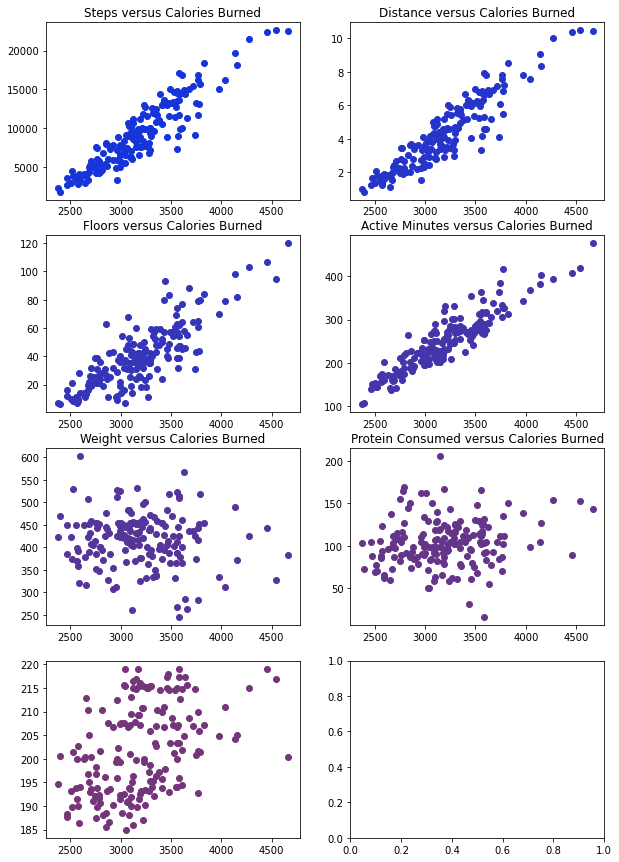

In [91]:
fig_calCorr, axs = plt.subplots (nrows = 4, ncols = 2, figsize = (10, 15))
axs[0, 0].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Steps'], c = '#1535DA')
axs[0, 0].set_title('Steps versus Calories Burned')

axs[0, 1].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Distance'], c = '#2535CA')
axs[0, 1].set_title('Distance versus Calories Burned')

axs[1, 0].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Floors'], c = '#3535BA')
axs[1, 0].set_title('Floors versus Calories Burned')

axs[1, 1].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Active Minutes'], c = '#4535AA')
axs[1, 1].set_title('Active Minutes versus Calories Burned')

axs[2, 0].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Minutes Asleep'], c = '#55359A')
axs[2, 0].set_title('Minutes Asleep versus Calories Burned')

axs[2, 1].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Protein Consumed'], c = '#65358A')
axs[2, 1].set_title('Protein Consumed versus Calories Burned')

axs[3, 0].scatter(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Weight'], c = '#75357A')
axs[2, 0].set_title('Weight versus Calories Burned')


From the histograms, I have a feeling that we won't be seeing any tests suggesting that we have normally distributed data. The scatterplots, on the other hand, do seem to show some potentially strong correlations between some of the features and the Calories Burned data. Let's check for normality by running a Shapiro-Wilk test for each feature.

In [45]:
stats.shapiro(calCorr.T.loc['Calories Burned'])

ShapiroResult(statistic=0.9727344512939453, pvalue=0.0016980086220428348)

In [46]:
stats.shapiro(calCorr.T.loc['Steps'])

ShapiroResult(statistic=0.9626308083534241, pvalue=0.00013134385517332703)

In [47]:
stats.shapiro(calCorr.T.loc['Distance'])

ShapiroResult(statistic=0.9624748826026917, pvalue=0.0001265646715182811)

In [48]:
stats.shapiro(calCorr.T.loc['Floors'])

ShapiroResult(statistic=0.9494779109954834, pvalue=7.172767709562322e-06)

In [49]:
stats.shapiro(calCorr.T.loc['Active Minutes'])

ShapiroResult(statistic=0.9822933673858643, pvalue=0.025996344164013863)

In [50]:
stats.shapiro(calCorr.T.loc['Minutes Asleep'])

ShapiroResult(statistic=0.9814915657043457, pvalue=0.020458366721868515)

In [51]:
stats.shapiro(calCorr.T.loc['Protein Consumed'])

ShapiroResult(statistic=0.98409104347229, pvalue=0.044695496559143066)

In [52]:
stats.shapiro(calCorr.T.loc['Weight'])

ShapiroResult(statistic=0.947303831577301, pvalue=4.608764356817119e-06)

Some features come close to the common 0.05 p-value threshold, but none go above to suggest a normal distribution. Because of this, we will use the Spearman's Ranked Correlation tests again to get our correlation values. Now we will get that value by comparing each feature to the Calories Burned data.

In [53]:
corrSteps = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Steps'])

print("Steps Correlation value: {}  p-value: {}".format(corrSteps[0], corrSteps[1]))

Steps Correlation value: 0.9092021165148391  p-value: 2.3558014056453693e-67


In [54]:
corrDist = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Distance'])

print("Distance Correlation value: {}  p-value: {}".format(corrDist[0], corrDist[1]))

Distance Correlation value: 0.9069157675641042  p-value: 1.8084102527990813e-66


In [55]:
corrFloors = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Floors'])

print("Floors Correlation value: {}  p-value: {}".format(corrFloors[0], corrFloors[1]))

Floors Correlation value: 0.7785496526494494  p-value: 1.2305353190506941e-36


In [56]:
corrActMin = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Active Minutes'])

print("Active Minutes Correlation value: {}  p-value: {}".format(corrActMin[0], corrActMin[1]))

Active Minutes Correlation value: 0.9040663292987411  p-value: 2.132838107309617e-65


In [57]:
corrMinSleep = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Minutes Asleep'])

print("Minutes Asleep Correlation value: {}  p-value: {}".format(corrMinSleep[0], corrMinSleep[1]))

Minutes Asleep Correlation value: -0.06369738402109121  p-value: 0.4037073276942029


In [58]:
corrProt = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Protein Consumed'])

print("Protein Consumed Correlation value: {}  p-value: {}".format(corrProt[0], corrProt[1]))

Protein Consumed Correlation value: 0.1592871074237617  p-value: 0.03577990077080173


In [59]:
corrWeight = stats.spearmanr(calCorr.T.loc['Calories Burned'], calCorr.T.loc['Weight'])

print("Weight Correlation value: {}  p-value: {}".format(corrWeight[0], corrWeight[1]))

Weight Correlation value: 0.442151916593881  p-value: 1.0082316631135168e-09


In [60]:
df_CorrComp = pd.DataFrame({'Feature':['Steps', 'Distance', 'Floors', 'Active Minutes', 'Minutes Asleep', 
                                       'Protein Consumed', 'Weight'], 
                           'Correlation Value':[corrSteps[0], corrDist[0], corrFloors[0], corrActMin[0], corrMinSleep[0], 
                                                corrProt[0], corrWeight[0]],
                           'p-value':[corrSteps[1], corrDist[1], corrFloors[1], corrActMin[1], corrMinSleep[1], 
                                      corrProt[1], corrWeight[1]]})
df_CorrComp

,Feature,Correlation Value,p-value
0,Steps,0.909202,2.355801e-67
1,Distance,0.906916,1.808410e-66
2,Floors,0.778550,1.230535e-36
3,Active Minutes,0.904066,2.132838e-65
4,Minutes Asleep,-0.063697,4.037073e-01
5,Protein Consumed,0.159287,3.577990e-02
6,Weight,0.442152,1.008232e-09


It looks like all features have significant evidence to suggest that there is a correlation except for Minutes Asleep based on the p-value being greater than 0.05. For this reason, I will remove the Minutes Asleep feature from future analysis.

In [61]:
df_CorrCompDrop = df_CorrComp.drop(index = 4).reset_index(drop = True)
df_CorrCompDrop

,Feature,Correlation Value,p-value
0,Steps,0.909202,2.355801e-67
1,Distance,0.906916,1.808410e-66
2,Floors,0.778550,1.230535e-36
3,Active Minutes,0.904066,2.132838e-65
4,Protein Consumed,0.159287,3.577990e-02
5,Weight,0.442152,1.008232e-09


Now that we selected for statistically signficant correlations, we can sort by the correlation values to see which features have results suggesting that they are most correlated with Calories Burned.

In [62]:
df_CorrCompSorted = df_CorrCompDrop.sort_values(by = 'Correlation Value', ascending = False)
df_CorrCompSorted

,Feature,Correlation Value,p-value
0,Steps,0.909202,2.355801e-67
1,Distance,0.906916,1.808410e-66
3,Active Minutes,0.904066,2.132838e-65
2,Floors,0.778550,1.230535e-36
5,Weight,0.442152,1.008232e-09
4,Protein Consumed,0.159287,3.577990e-02


Perhaps it is by no surprise, but it seems that the activity based features hold a strong lead over Weight, a body feature, and Protein Consumed, a food feature. 

Text(0.5, 1.0, 'Correlation Values of Features Compared to Calories Burned')

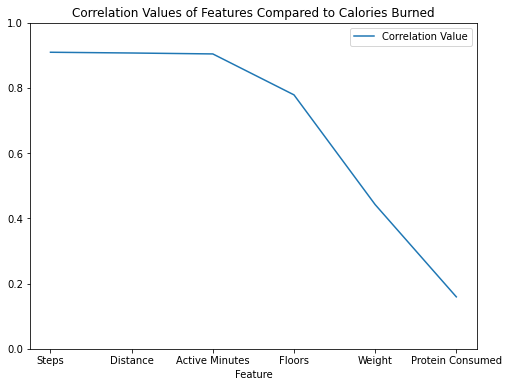

In [63]:
CorrPlot = df_CorrCompSorted.plot(x = 'Feature', y = 'Correlation Value', figsize = (8, 6), ylim = (0, 1))
plt.title('Correlation Values of Features Compared to Calories Burned')

So, based on the results above, the top 3 features that are most correlated with the Calories Burned data are Steps, Distance, and Active Minutes in that order. 

### Conclusion


For this project, I aimed to complete some basic level cleaning, visualization, and analyzation to explore data. I was able to practice this in a way that was fun and associated with other interests in my life. I value this project as a good exercise and demonstration of my knowledge at this point in my academic and professional career. If I were to repeat this project in the future, I would focus on improving the food logging system to include more micronutrients and increase overall accuracy, add recurring surveys to gauge stress and mental health, perform the recording for a longer duration to have a larger dataset, mark points in time where I have specific restrictions or goals related to food and/or my body, and improve the utility functions so that they are more adaptable for others who may wish to complete a similar project with their Fitbit data.

#### Sources

[1] Google LLC. (2022). _Fitbit_ (Version 3.72) [Mobile App]. App Store. https://apps.apple.com/us/app/fitbit-health-fitness/id462638897 \
[2] Nuttall F. Q. (2015). Body Mass Index: Obesity, BMI, and Health: A Critical Review. Nutrition today, 50(3), 117–128. https://doi.org/10.1097/NT.0000000000000092 \
[3] Humayun, M. A., Elango, R., Ball, R. O., & Pencharz, P. B. (2007). Reevaluation of the protein requirement in young men with the indicator amino acid oxidation technique. The American journal of clinical nutrition, 86(4), 995-1002. https://academic.oup.com/ajcn/article/86/4/995/4649413 \
[4] Centers for Disease Control and Prevention. (2022). About Sodium. Centers for Disease Control and Prevention. https://www.cdc.gov/salt/food.htm \
[5] American Heart Association. (2022). How much sodium should I eat per day? www.heart.org. https://www.heart.org/en/healthy-living/healthy-eating/eat-smart/sodium/how-much-sodium-should-i-eat-per-day#:~:text=There's%20no%20reliable%20evidence%20that,in%20less%20than%20%C2%BC%20teaspoon.